In [ ]:
!pip install scanpy leidenalg

In [ ]:
!pip install torchsummary

In [ ]:
# ! pip install -q kaggle

In [ ]:
# ! kaggle datasets download -d albertozorzetto/rnaseq-aging-dementia-and-tbi

In [ ]:
import scanpy              as sc
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
from   PIL     import Image
from   zipfile import ZipFile
import re
import os
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import lr_scheduler
from torch.distributions import Normal

from torchsummary import summary

# Create custom legend
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
# import fastcluster
# import igraph

In [ ]:
!kaggle datasets download -d albertozorzetto/rnaseq-aging-dementia-and-tbi

Dataset URL: https://www.kaggle.com/datasets/albertozorzetto/rnaseq-aging-dementia-and-tbi
License(s): CC0-1.0
rnaseq-aging-dementia-and-tbi.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
class Preprocess:

  def __init__(self, zip_file):
    self.zip_file                                                            = zip_file
    self.data, self.fpkm_normalized, self.fpkm_unnormalized, self.rows_genes = self._open_zip(self.zip_file)
    # self.data, self.ids, self.phase_intensity = self._preprocess_files(self.data,
                                                                        # self.ids, self.phase_intensity)
    # self.data_obj = self._create_second_data(self.data)


  def _open_zip(self, zip_file):

    with ZipFile(zip_file) as zip:
      print(zip.namelist())
      with zip.open(zip.namelist()[0]) as f: # Loading as AnnData Scanpy Objects
        data       = pd.read_csv(f)
        data.index = data[data.columns[0]]
        data       = data.drop(columns = [data.columns[0], data.columns[1]])

      with zip.open('fpkm_table_normalized.csv') as f:
        fpkm_normalized        = pd.read_csv(f)
        fpkm_normalized        = fpkm_normalized.set_index(fpkm_normalized.columns[0])
        fpkm_normalized        = fpkm_normalized.drop(columns = fpkm_normalized.columns[0])
        fpkm_normalized        = fpkm_normalized.transpose()

      with zip.open('fpkm_table_unnormalized.csv') as f:
        fpkm_unnormalized = pd.read_csv(f)


      with zip.open('rows-genes.csv') as f:
        rows_genes        = pd.read_csv(f)


      return data, fpkm_normalized, fpkm_unnormalized, rows_genes

  def _preprocess_files(self):

      return

  def _create_second_data(self, data):
      data_obj         = data.copy()
      data_obj.columns = self.original_indexes
      return data_obj


Preprocess_object    = Preprocess('rnaseq-aging-dementia-and-tbi.zip')
data                 = Preprocess_object.data
fpkm_normalized      = Preprocess_object.fpkm_normalized

fpkm_unnormalized    = Preprocess_object.fpkm_unnormalized
rows_genes           = Preprocess_object.rows_genes

donor_structure_dict = {list(data.index)[index]: list(data['structure_acronym'])[index] for index in range(len(data))}
id_symbol_dict       = rows_genes.set_index('gene_id')['gene_symbol'].to_dict()
gene_labels          = pd.Series(fpkm_normalized.columns).apply(lambda x: id_symbol_dict[x])

patient_brain_meta   = pd.Series(fpkm_normalized.index).apply(lambda x: donor_structure_dict[int(x)] if int(x) in donor_structure_dict else np.nan)
fpkm_normalized.columns         = list(gene_labels)



In [ ]:
data['structure_name'].value_counts()

structure_name
temporal neocortex                     99
hippocampus (hippocampal formation)    94
white matter of forebrain              93
parietal neocortex                     91
Name: count, dtype: int64

# GSEA Workflow
1. Gene_Symbols are in Entrez/Ncbi/HGNC Id nomenclature


In [ ]:
!pip install gseapy

In [ ]:
import gseapy as gp

def load_gene_dicts(prefix):

  gene_dict  = {'GOBP': f'{prefix}GO_Biological_Process_2023.gmt',
               'GOCC': f'{prefix}/GO_Cellular_Component_2023.gmt',
               'GOMF': f'{prefix}/GO_Molecular_Function_2023.gmt',
               'KEGG':f'{prefix}/KEGG_2019_Mouse.gmt',
               'Hallmark': f'{prefix}/MSigDB_Hallmark_2020.gmt',
               'Reactome': f'{prefix}/Reactome_2022.gmt'}

  library_dict = {}
  for name, library in gene_dict.items():
    library            = gp.read_gmt(gene_dict[name])
    library_dict[name] = library

  return library_dict

prefix = '/content/drive/MyDrive/DataScience/Portfolio Development/Clustering/RNASeq/GSEA_RNAseq/gene_libraries/'

# Beginning of the folder paths
# prefix = 'gene_libraries/'
library_dict = load_gene_dicts(prefix)


In [ ]:
data['structure_name'].value_counts()

In [ ]:
def choose_subset(fpkm_normalized, patient_brain_meta, group1, group2):
	'''
	Parameters:
		fpkm_Normalized:
		patient_brain_meta:
		group1:
		group2:

		(White Matter Brain (FWM),
		temporal neocortex (TCx),
		hippocampus (HIP),
		parietal neocortex (PCx))

	Returns:

	'''

	fpkm_normalized = fpkm_normalized.transpose()
	fpkm_normalized.columns = list(patient_brain_meta)
	gsea_input      = fpkm_normalized[[group1, group2]]
	gsea_input      = np.log2(gsea_input + 1)

	return gsea_input


gsea_input = choose_subset(fpkm_normalized, patient_brain_meta,
						              group1 = 'FWM',
							            group2 = 'HIP')


In [ ]:
def run_gsea(data, library_dict, one_library = True, library_choice = 'KEGG'):

    enrichments_results = {}
    enrichment_objects  = {}
    condition_names     = data.columns
    for name, library in library_dict.items():

        if one_library:
            library = library_dict[library_choice]
            name    = library_choice

        gsea_results    = gp.gsea(data=gsea_input, # or use df directly
                            gene_sets= library, # Path to GMT file
                            cls = condition_names, # phenotype labels as list
                            permutation_num=200, # default is 1000,
                            outdir=None, # Output directory
                            # min_size=15, # Minimum size of genes in a set
                            # max_size=500, # Maximum size of genes in a set
                            permutation_type='phenotype', # Phenotype label permutation
                            method = 'signal_to_noise',
                            seed=6) # Seed for reproducibility

        enrichments_results[name] = gsea_results.res2d
        enrichment_objects[name]  = gsea_results

        if one_library:
            break

    return enrichments_results, enrichment_objects

enrichment_results, enrichment_objects = run_gsea(gsea_input, library_dict)

In [ ]:
def plot_hmaps():
# Iterate over significant gene sets
    for name, row in enrichment_objects['KEGG'].res2d.iterrows():
        name = row['Term']

        if name == 'Glycerolipid metabolism':
            if float(row['NOM p-val']) < 0.01:  # Filter significant gene sets based on p-value
                gene_list = row['Lead_genes'].split(';')
                plt.figure(figsize=(9, 6.4))
                subset    = gsea_input.loc[gene_list]
                ax = gp.plot.heatmap(df=subset, gene_list=gene_list, title=row['Term'], cmap = 'coolwarm')

                   # Determine positions for labels
                num_genes = len(gene_list)
                left_half_index = 2* num_genes  # Midpoint of the left half
                right_half_index = 5 * num_genes #// 4  # Midpoint of the right half

                # Set custom x-ticks and labels
                ax.set_xticks([left_half_index, right_half_index])
                ax.set_xticklabels(['White Matter of Forebrain', 'Hippocampus'])  # Custom labels for clarity

                plt.xticks(rotation = 70)
                # plt.xticks([])  # Hide x-ticks completely


            break
            # plt.savefig(f'gsea_output/{name}_heatmap.png')
                # plt.close()


plot_hmaps()



# Variational AutoEncoder Workflow
1. Variational Autoencoder Representations vs. PCA

In [ ]:
class Encoder(nn.Module):

    def __init__(self,
                 input_dim,
                 variational,
                 embedding_dim = 16,
                 num_layers    = 2,
                 latent_dim    = 2):

        super().__init__()

        P = 0

        self.variational              = variational
        self.first_embedding          = embedding_dim * 2
        self.embedding_dim            = embedding_dim
        self.latent_dim               = latent_dim

        self.num_layers               = num_layers
        # self.dropout                  = nn.Dropout(p=0.3)
        self.linear                   = nn.Linear(input_dim, self.first_embedding)
        self.linear2                  = nn.Linear(self.first_embedding, self.embedding_dim)
        # self.linear3                  = nn.Linear(self.embedding_dim, self.embedding_dim)
        self.mu                       = nn.Linear(self.embedding_dim, self.latent_dim)
        self.log_var                  = nn.Linear(self.embedding_dim, self.latent_dim)

        # self.gru                      = nn.GRU(embedding_dim, latent_dim, batch_first=True)

        self.dropout                  = nn.Dropout(P)
        self.dropout2                 = nn.Dropout(P)
        self.dropout3                 = nn.Dropout(P)

        self.batch_norm1              = nn.BatchNorm1d(self.first_embedding)
        self.batch_norm2              = nn.BatchNorm1d(self.embedding_dim)
        self.batch_norm3              = nn.BatchNorm1d(self.embedding_dim)


    def forward(self, x):
        # x                =   self.dropout(self.embedding(x))
        # x                =

        x                = F.relu(self.batch_norm1(self.linear(x)))
        # x                = self.dropout(x)
        # x                = F.relu(self.linear(x))

        x                = F.relu(self.batch_norm2(self.linear2(x)))
        # x                = self.dropout2(x)
        # x                = F.relu(self.linear2(x))

        mu               = self.mu(x)
        log_var          = self.log_var(x)

        # Learn a probabilistic output based on a guassian distribution
        if self.variational:
          std              = torch.exp(0.5 * log_var)
          q                = Normal(mu, std)
          z                = q.rsample()

          return x, mu, log_var, z

        # Learn a fixed output
        elif not self.variational:

          return mu



class DecoderAttention(nn.Module):

    def __init__(self,
                decoder_output_dim,
                latent_dim,
                hidden_size = 128,
                input_dim   = 64,
                ):

        super().__init__()
        p                     = 0

        self.output_dim       = decoder_output_dim
        self.hidden_dim       = hidden_size
        self.latent_dim       = latent_dim

        self.linear           = nn.Linear(latent_dim, hidden_size)
        self.linear2          = nn.Linear(hidden_size, hidden_size*2)
        self.linear3          = nn.Linear(hidden_size*2, hidden_size*4)

        self.dropout1         = nn.Dropout(p = p)
        self.dropout2         = nn.Dropout(p = p)

        # self.mean_output           = nn.Linear(hidden_size*4, self.output_dim)
        # self.dispersion_output     = nn.Linear(hidden_size*4, self.output_dim)
        # self.zero_inflation_output = nn.Linear(hidden_size*4, self.output_dim)

        self.out                   = nn.Linear(hidden_size*4, self.output_dim)

        self.batch_norm1           = nn.BatchNorm1d(hidden_size)
        self.batch_norm2           = nn.BatchNorm1d(2*hidden_size)
        self.batch_norm3           = nn.BatchNorm1d(4*hidden_size)

    def forward(self, z):

        batch_size      = z.size(1)
        output          = F.relu(self.batch_norm1(self.linear(z)))
        output          = F.relu(self.batch_norm2(self.linear2(output)))
        output          = F.relu(self.batch_norm3(self.linear3(output)))

        output          = self.out(output)

        return output
        # Initialize LSTM Hidden and Cell States (Num LSTM Layers, Batch Size, Hidden Size)


class VAE(nn.Module):

    def __init__(self,
                 gene_encoder,
                 decoder,
                 input_dim,
                 decoder_output_dim,
                 option,
                 variational = True):

        super().__init__()

        self.variational        = variational
        self.option             = option
        self.gene_encoder       = gene_encoder
        # self.drug_encoder       = drug_encoder
        self.decoder            = decoder

        self.latent_dim         = self.gene_encoder.latent_dim
        self.input_dim          = input_dim
        self.decoder_output_dim = decoder_output_dim


    def forward(self, x_gene):

        if self.option == 'gene encoder' and self.variational:
            x, mu, log_var, z   = self.gene_encoder(x_gene)
            std = torch.exp(0.5 * log_var)
            q   = Normal(mu, std)
            z   = q.rsample()
            x_recon      = self.decoder(z)
            mu           = mu.squeeze(0)
            log_var      = log_var.squeeze(0)
            x_recon      = x_recon.squeeze(0)

            return x_recon, mu, log_var, z

        elif self.option == 'gene encoder' and not self.variational:
            z                   = self.gene_encoder(x_gene)
            x                   = self.decoder(z)
            return x, z




def custom_mean_rowwise_rmse(y_true, y_pred):
    """
    Custom metric to calculate the Mean Rowwise Root Mean Squared Error (RMSE).

    Parameters:
    - y_true: The true target values, a PyTorch tensor.
    - y_pred: The predicted values, a PyTorch tensor.

    Returns:
    - Mean Rowwise RMSE as a scalar tensor.
    """

    # Calculate squared difference
    squared_diff = (y_true - y_pred) ** 2

    # Calculate mean squared error for each row
    mse_per_row = torch.mean(squared_diff, dim=1)

    # Calculate root mean squared error for each row
    rmse_per_row = torch.sqrt(mse_per_row)

    # Calculate the mean of RMSE values across all rows
    mean_rmse = torch.mean(rmse_per_row)

    return mean_rmse

# Variational AutoEncoder Code
def loss_function(x, x_recon, mu, log_var, beta = 0.3):
    recon_loss = custom_mean_rowwise_rmse(x, x_recon)
    kl_div     = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return recon_loss + beta * kl_div

In [ ]:
def build_model(input_data, option, variational = True):


  gene_encoder = Encoder(input_dim = input_data.shape[1], variational = variational)

  decoder      = DecoderAttention(decoder_output_dim = input_data.shape[1], latent_dim = gene_encoder.latent_dim)
  vae          = VAE(gene_encoder,
                 decoder,
                 input_dim = input_data.shape[1],
                 decoder_output_dim = input_data.shape[1],
                 option = option,
                 variational = variational)


  return vae



variational = False
vae = build_model(gsea_input.transpose(), option = 'gene encoder', variational = variational)

In [ ]:
def train_model(model, x_train_gene, x_val_gene, variational):

    epochs       = 20
    lr           = 0.003
    loss_fn      = loss_function
    optimizer    = torch.optim.Adam(model.parameters(), lr = lr)
    scheduler    = lr_scheduler.ExponentialLR(optimizer, gamma = 0.8)

    batch_size   = 32
    batches      = math.floor(x_train_gene.shape[0] / batch_size)
    x_train_gene = torch.tensor(x_train_gene.values, dtype=torch.float32)
    # x_train_drug = torch.tensor(x_train_drug.values, dtype=torch.float32)

    # x_val_drugs  = torch.tensor(x_val_drugs.values, dtype = torch.float32)
    y_val_gene   = torch.tensor(x_val_gene.values, dtype = torch.float32)
    # MSE_loss     = nn.MSELoss()

    losses       = []


    for epoch in range(epochs):
        if variational:
            intermediate_losses          = []
            for batch in range(1, batches + 1):

                train_gene               = x_train_gene[(batch - 1)*batch_size:batch*batch_size]

                # Variational Autoencoder
                x_recon, mu, log_var, z  = model.forward(train_gene)

                # AutoEncoder

                loss                     = loss_fn(train_gene, x_recon, mu, log_var)
                # loss                    = MSE_loss(x_recon, train_gene)
                # loss                  = loss_fn(train_drug, x_recon, mu, log_var)
                intermediate_losses.append(loss.detach().numpy())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step(loss)


            intermediate_losses = np.average(intermediate_losses)
            losses.append(intermediate_losses)

            # Validation

            val_dataset = TensorDataset(y_val_gene, y_val_gene)
            val_loader  = DataLoader(val_dataset, batch_size=32, shuffle=False)
            val_loss    = []
            with torch.no_grad():

                for x_val, _ in val_loader:
                    x_recon_val, mu_val, log_var_val, z_val = model(x_val)
                    loss = loss_fn(x_recon_val, x_val, mu_val, log_var_val)  # Assuming full_targets are your entire targets
                    # total_loss = loss.item()
                    val_loss.append(loss.detach().numpy())

                val_loss = np.average(val_loss)

        elif not variational:
            loss_fn                       = nn.MSELoss()
            intermediate_losses           = []
            for batch in range(1, batches + 1):

                train_gene               = x_train_gene[(batch - 1)*batch_size:batch*batch_size]

                # Autoencoder
                x_recon, z               = model.forward(train_gene)


                loss                    = loss_fn(train_gene, x_recon)

                intermediate_losses.append(loss.detach().numpy())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step(loss)


            intermediate_losses = np.average(intermediate_losses)
            losses.append(intermediate_losses)

            # Validation

            val_dataset = TensorDataset(y_val_gene, y_val_gene)
            val_loader  = DataLoader(val_dataset, batch_size=32, shuffle=False)
            val_loss    = []
            with torch.no_grad():

                for x_val, _ in val_loader:
                    x_recon_val, _ = model(x_val)
                    loss = loss_fn(x_recon_val, x_val)  # Assuming full_targets are your entire targets
                    # total_loss = loss.item()
                    val_loss.append(loss.detach().numpy())

                val_loss = np.average(val_loss)


        # print('Training Loss: ', intermediate_losses)
        print(f'Epoch {epoch + 1}: Training Loss: ', intermediate_losses, ' | Validation Loss: ', val_loss)

    return model


# NEXT STEP 23 oct 2023 evaluate the model
x_train, x_test, _, _ = train_test_split(gsea_input.transpose(),
                                        gsea_input.transpose(),
                                        random_state = 42,
                                        test_size = 0.2)

x_test, x_val, _, _   = train_test_split(x_test, x_test, random_state = 42, test_size = 0.5)


vae_model             = train_model(vae, x_train, x_val, variational)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1: Training Loss:  3.0342152  | Validation Loss:  1.6493281
Epoch 2: Training Loss:  1.1695765  | Validation Loss:  0.59323967
Epoch 3: Training Loss:  0.51409733  | Validation Loss:  0.54552007
Epoch 4: Training Loss:  0.45610335  | Validation Loss:  0.439943
Epoch 5: Training Loss:  0.27749106  | Validation Loss:  0.32808414
Epoch 6: Training Loss:  0.20057213  | Validation Loss:  0.27503973
Epoch 7: Training Loss:  0.15540229  | Validation Loss:  0.27969128
Epoch 8: Training Loss:  0.11964337  | Validation Loss:  0.24849863
Epoch 9: Training Loss:  0.09653839  | Validation Loss:  0.2400635
Epoch 10: Training Loss:  0.081867695  | Validation Loss:  0.21277186
Epoch 11: Training Loss:  0.074247204  | Validation Loss:  0.19593863
Epoch 12: Training Loss:  0.067676455  | Validation Loss:  0.20980392
Epoch 13: Training Loss:  0.0633096  | Validation Loss:  0.19758429
Epoch 14: Training Loss:  0.06023533  | Validation Loss:  0.18865891
Epoch 15: Training Loss:  0.05817644  | Validat

In [ ]:
if variational:
  x_recon, mu, log_var, z = vae_model(torch.tensor(gsea_input.transpose().values, dtype = torch.float32))

elif not variational:
  x, z        = vae_model(torch.tensor(gsea_input.transpose().values, dtype = torch.float32))

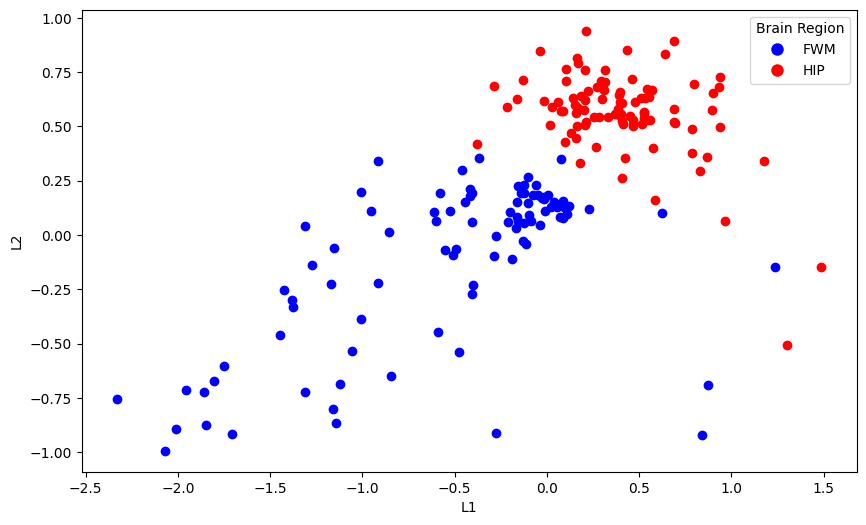

In [ ]:
def scatter_plot(latent_samples, label1, label2):
  plt.figure(figsize=(10, 6))  # Set the size of the figure
  color_map   = {'FWM': 'blue', 'HIP': 'red'}
  used_labels = set()

  for i, point in latent_samples.iterrows():
    label = point['Brain Region']
    if label not in used_labels:
        plt.scatter(point[label1], point[label2], color=color_map[label], label=label)
        used_labels.add(label)
    else:
        plt.scatter(point[label1], point[label2], color=color_map[label])

      # plt.scatter(point['L1'], point['L2'], color = color_map[point['Brain Region']], label=point['Brain Region'] if point['Brain Region'] not in plt.gca().get_legend_handles_labels()[1] else "")
      # # plt.text(point['L1'], point['L2'], f"{point['Brain Region']}", fontsize=6)

  legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
                            markerfacecolor=color, markersize=10)
                    for key, color in color_map.items()]
  plt.legend(handles=legend_elements, title="Brain Region")

  # Optionally set labels and title
  plt.xlabel(label1)
  plt.ylabel(label2)

  return

latent_samples = pd.DataFrame(z.detach().numpy(), columns = ['L1', 'L2'])
latent_samples = pd.concat([latent_samples, pd.Series(gsea_input.columns, name = 'Brain Region')], axis = 1)
# latent_samples
scatter_plot(latent_samples, label1 = 'L1', label2 = 'L2')

In [ ]:
vae_model.eval()
# Using torchsummary to summarize the mode
summary(vae_model,input_size= gsea_input.transpose().shape, device='cpu')  # Ensure the input size matches your model's inpu

[0.32637865 0.09477537]


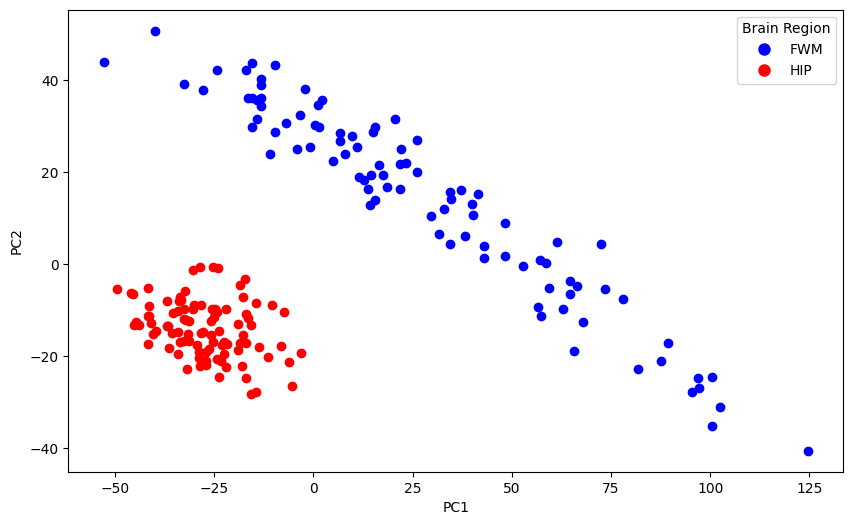

In [ ]:
from sklearn.decomposition import PCA

pca          = PCA(n_components = 2)
x_pca        = pca.fit_transform(gsea_input.transpose())

x_pca        = pd.DataFrame(x_pca, columns = ['PC1', 'PC2'])
x_pca        = pd.concat([x_pca, pd.Series(gsea_input.columns, name = 'Brain Region')], axis = 1)
scatter_plot(x_pca, label1 = 'PC1', label2 = 'PC2')

print(pca.explained_variance_ratio_)

**Xgboost**

In [ ]:
!pip install xgboost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score
import xgboost as xgb

def prepare_data(x_data, y_data, SEED = 42, TEST_SIZE = 0.2):

  y_data = pd.factorize(y_data)[0]
  x_train, y_train, x_test, y_test = train_test_split(x_data, y_data, test_size = TEST_SIZE, random_state = SEED)

  return x_train, y_train, x_test, y_test


# x_train, x_test, y_train, y_test = prepare_data(x_pca[['PC1', 'PC2']], x_pca['Brain Region'])
x_train, x_test, y_train, y_test = prepare_data(latent_samples[['L1', 'L2']], latent_samples['Brain Region'])



# Initialize the XGBoost classifier
clf = xgb.XGBClassifier(
      n_estimators=100,
      learning_rate=0.1,
      max_depth=5,
      subsample=0.5,
      colsample_bytree=0.5,
      objective='binary:logistic',  # Objective function for binary classification
      random_state=42
)

# Fit the classifier to the training data
clf.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
accuracy_score(clf.predict(x_test), y_test)

1.0

# Example "Single-Cell" Workflow
1. Samples are from individual patients but Scanpy can still be used for visualization and other prebuilt functions

In [ ]:
class ScanpyObject:

  # Data: Gene x Cell Row Matrix with Cells in index
  #       Columns Gene IDS correspond to the Columns

  # Leiden Groups: # of Groups for Clustering In Leiden Algorithm
  # Random State: The random seed introduced to Python for reproducability
  # PCA, UMAP, and TSNE utilitze a stochastic gradient algorithm (starting point matters)
  # PCA is determinsitic but due to the high rank of these datasets, "random PCA" may be used

  # Metalables: Title of Column Describing Gene Categorization
  #             For example: mRNA, Protein coding, siRNA, etc.,

  # Regressor: Value that determines how to remove some data, commonly mitochondrial based.

  def __init__(self, data, ids, regressor, leiden_groups = 15, random_state = 42, metalabels = 'protein_coding'):

    self.data_object        = sc.AnnData(data)
    self.data_highvar       = None
    self.leiden_gene_groups = leiden_groups   # TSNE Plots leiden groups
    self.random_state       = random_state    # Seed For Reproducability
    self.ids                = ids             # Metalabel variable for group comparisons

    sc.pp.normalize_total(self.data_object)
    sc.pp.log1p(self.data_object)
    sc.pp.highly_variable_genes(self.data_object, min_mean=0.0125, max_mean=3, min_disp=0.5)
    self._preprocess_workflow(metalabels)
    self._regress_highvar(regressor)
    self._nearest_neighbors()
    self._dimension_reduction()

  def _dimension_reduction(self):
    sc.pp.pca(self.data_highvar, svd_solver = 'arpack', random_state = self.random_state)
    sc.tl.pca(self.data_highvar, svd_solver = 'arpack')
    sc.tl.rank_genes_groups(self.data_highvar, 'leiden', method='t-test')

  def _preprocess_workflow(self, metalabels):
    self._filter_cells()
    self._attach_metalabels(metalabels)
    self._calculate_qc_metrics()

  # Creates Another Object, With High Variability Genes Only
  def _regress_highvar(self, regressor):

    self.data_highvar  = self.data_object[:, self.data_object.var.highly_variable]

    sc.pp.regress_out(self.data_highvar, ['total_counts', regressor])

  # Leiden Clustering
  def _nearest_neighbors(self):
    sc.pp.neighbors(self.data_highvar, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(self.data_highvar) # calculate the neighbors

  def _retreive_ranked_groups(self):
    gene_groups     = self.leiden_gene_groups
    gene_ranks_list = list(self.data_highvar.uns['rank_genes_groups']['names'])
    if len(gene_ranks_list) != 0:
      ranked_groups = gene_ranks_list[:gene_groups]

    return ranked_groups

  def _filter_cells(self):
    sc.pp.filter_cells(self.data_object, min_counts = 200)

  def _attach_metalabels(self, metalabels):
    for metalabel in self.ids[metalabels].unique():
      self.data_object.var[metalabel] = self.data_object.var_names.str.startswith(metalabel)

  def _calculate_qc_metrics(self):

    self.non_qc = ['highly_variable', 'means', 'dispersions', 'dispersions_norm']
    self.qc     = [col for col in self.data_object.var if col not in self.non_qc]

    sc.pp.calculate_qc_metrics(self.data_object, qc_vars=self.data_object.var[self.qc],
                                           percent_top=None, log1p=False, inplace=True)

  def leiden_ranking(self):
    sc.pl.rank_genes_groups(self.data_highvar, n_genes=self.leiden_gene_groups, sharey=False)

  def marker_genes(self):
    markers       = 2
    ranked_groups = self._retreive_ranked_groups()
    top_ranked    = {value: list(ranked_groups[value])[0:markers] for value in range(len(ranked_groups))}

    return top_ranked

  # -------------------------------------------------------------------------------------
  # Plot UMAP Takes The Highest Rank Marker Gene and Plots with UMAP
  # UMAP (Unifold Manifold) is a technique that aims to separate similar groups
  # UMAP is purely a visual technqiue, meaning the axes have no meaning
  # Separation does indicate that the groups are similar, but not as interpretable as PCA

  def plot_umap(self, color_type = 'highly_variable'):
    highly_variable = self.marker_genes()
    highly_variable = list(highly_variable.values())
    highly_variable = [gene[0] for gene in highly_variable]

    # # highly_variable = ['ENSG00000001561', 'ENSG00000286231']
    sc.tl.paga(self.data_highvar)
    sc.pl.paga(self.data_highvar, plot     =  False)  # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.umap(self.data_highvar, init_pos = 'paga')
    if color_type == 'highly_variable':
      sc.pl.umap(self.data_highvar, color=highly_variable)
    else:
      sc.pl.umap(self.data_highvar, color = color_type)

  def pca(self, gene_id = None):
    if gene_id is None:
      raise KeyError('Gene ID must be passed from host dataset')
    else:
      sc.pl.pca(self.data_highvar, color = gene_id, annotate_var_explained = True)

  def plot_high_expr(self):
    sc.pl.highest_expr_genes(self.data_object, n_top = 20)

  def plot_tsne(self):
    sc.tl.tsne(self.data_highvar, use_rep = 'X_pca')
    sc.pl.tsne(self.data_highvar, color=["leiden"], cmap="tab20")

  def scatter_plots(self):
    if not self.data_object.var.empty:
      total_plots = len(self.data_object.var.columns)
      fig, ax     = plt.subplots(8,5, figsize=(40,24))
      row         = 0
      col         = 0
      for plot in range(total_plots):
          protein_type = str(self.data_object.var.columns[plot])
          try:
            sc.pl.scatter(self.data_object, x='total_counts',
                          y = 'pct_counts_' + protein_type, ax = ax[row, col], show = False)
          # Deal with ax[row, col] calling for

          # Total Counts, n_genes_counts, etc
          except ValueError:
            col -= 1     # Counter Col += 1 Count


          col += 1
          if col > 4:
              row += 1
              col = 0
    else:
      raise ValueError(f'''{self.data_object.var} does not contain any data. Preprocess
      metalabels to receive scatter plots''')

  def plot_highly_variable(self):
    sc.pl.highly_variable_genes(self.data_object)

  def plot_pca_variance_ratio(self):
    sc.pl.pca_variance_ratio(self.data_highvar, log=True)

scanpy_obj1 = ScanpyObject(fpkm_normalized, rows_genes, 'pct_counts_MT', metalabels = 'chromosome')     # meta indexes data
# scanpy_obj2 = ScanpyObject(data_obj) # original indexes data

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


KeyboardInterrupt: 

In [ ]:
scanpy_obj1.data_highvar

In [ ]:
scanpy_obj1.pca(gene_id = '496100445')

In [ ]:
scanpy_obj1.scatter_plots()

In [ ]:
scanpy_obj1.plot_pca_variance_ratio()

In [ ]:
scanpy_obj1.marker_genes()

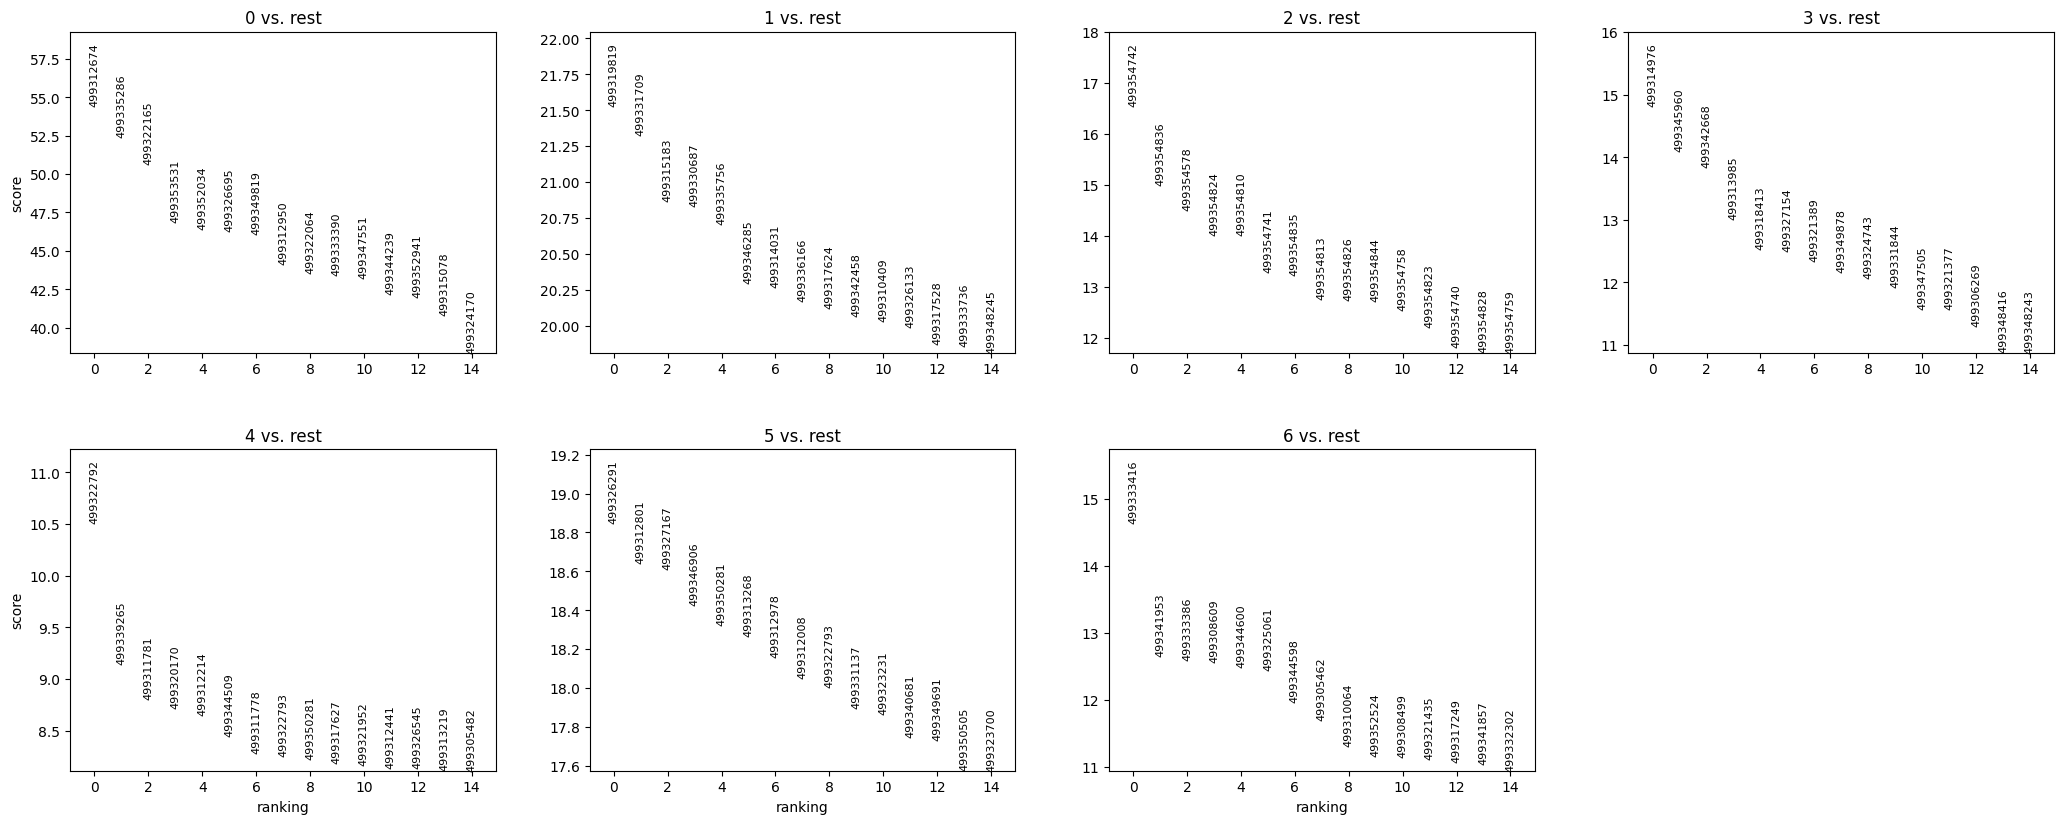

In [ ]:
scanpy_obj1.leiden_ranking()

In [ ]:
rows_genes.where(rows_genes['chromosome'] == '15').dropna()

In [ ]:
# rows_genes['gene_id']['499304660']
target = 496100445
index  = rows_genes.where(rows_genes['gene_id'] == target).dropna()
index

In [ ]:
data

,donor_name,specimen_id,specimen_name,rna_well_id,polygon_id,structure_id,structure_acronym,structure_color,structure_name,hemisphere
rnaseq_profile_id,,,,,,,,,,
488395315,H14.09.030,309357843,H14.09.030.TCx.01,395325172,320817998,10235,TCx,#ebbfd0,temporal neocortex,left
496100277,H14.09.004,309357624,H14.09.004.PCx.01,320630866,310967169,10557,FWM,#f2f1f0,white matter of forebrain,right
496100278,H14.09.001,309357596,H14.09.001.PCx.01,320630834,310790571,10557,FWM,#f2f1f0,white matter of forebrain,left
496100279,H14.09.001,309357599,H14.09.001.TCx.01,320630838,310790522,10235,TCx,#ebbfd0,temporal neocortex,left
496100281,H14.09.002,309357603,H14.09.002.HIP.01,320630842,310790372,10294,HIP,#bfb5d5,hippocampus (hippocampal formation),right
...,...,...,...,...,...,...,...,...,...,...
496100667,H15.09.103,467179071,H15.09.103.TCx.01,482655826,480366830,10235,TCx,#ebbfd0,temporal neocortex,right
496100669,H15.09.103,467179068,H15.09.103.PCx.01,482655822,480363830,10557,FWM,#f2f1f0,white matter of forebrain,right
496100670,H15.09.107,467179104,H15.09.107.TCx.01,482655780,480363840,10235,TCx,#ebbfd0,temporal neocortex,right


In [ ]:
data.loc[target]

donor_name                                    H14.09.052
specimen_id                                    309358017
specimen_name                          H14.09.052.HIP.01
rna_well_id                                    472517891
polygon_id                                     470531240
structure_id                                       10294
structure_acronym                                    HIP
structure_color                                  #bfb5d5
structure_name       hippocampus (hippocampal formation)
hemisphere                                         right
Name: 496100445, dtype: object